In [1]:
# !conda install -c conda-forge librosa

# !conda install tqdm

In [2]:
import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import hyperparams
from hyperparams import Hyperparams as params
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
from dcttsModel import C,Cs,Css,D,HC,TextEnc,AudioEnc,AudioDec,Text2Mel,SSRN
# reload(dcttsModel)

In [3]:
# conv = C(3,2,3,1,0)
# tconv = D(3,2,2,1,2)
# hconv = HC(2,2,3,1,0)
# I.shape,conv(I).shape,tconv(I).shape,hconv(I).shape

In [4]:
# # textEnc = TextEnc(d=d,e=e,c2i=c2i)
# # audioEnc = AudioEnc(d=d,F=F)
# audioDec = AudioDec(d=params.d,F=params.F).to(dev)

# ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
# text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

# # alpha = 0.5, super-separable
# [sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,audioDec,ssrn)]

In [5]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [6]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A):
        _,N,T = A.shape
        W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*params.g**2)) 
                        for t in range(1,T+1)] 
                       for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()

In [7]:
L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def MelFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [9]:
def saveChkpt(state,model,root='.'):
#     chkptDir = os.path.join(root,'CHKPT'+''.join(p+str(v) for p,v in state['archparams']))
    chkptDir = root
    chkptPath = os.path.join(chkptDir,model+'Chkpt.pth.tar')
    bestPath = os.path.join(chkptDir,model+'Best.pth.tar')
    if not os.path.exists(chkptDir): os.makedirs(chkptDir)    
    ch.save(state,chkptPath)
    if state['lossHist'][-1] == state['bestLoss']:
        shutil.copyfile(chkptPath,bestPath)
    print("SAVED EPOCH {}, LOSS {}, BEST LOSS {}".format(state['epoch'],state['lossHist'][-1],state['bestLoss']))

def loadChkpt(network,optimizer,model,dev,root='.'):
    # return epoch num and best loss of checkpoint
    chkptDir = root
    chkptPath = os.path.join(chkptDir,model+'Chkpt.pth.tar')
    bestPath = os.path.join(chkptDir,model+'Best.pth.tar')
    if not os.path.exists(chkptPath): return 0,[],float('inf')
    state = ch.load(chkptPath,map_location=dev)
    network.load_state_dict(state['modelState'])
    optimizer.load_state_dict(state['optimizerState'])
    if len(state['lossHist']) > 10: plt.plot(state['lossHist'])
    print("LOADED EPOCH {}, LOSS {}, BEST LOSS {}".format(state['epoch'],state['lossHist'][-1],state['bestLoss']))
    return state['epoch'],state['lossHist'],state['bestLoss']

In [17]:
import datasets
from importlib import reload
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)

text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)

text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                          lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 0
if load:
    startEpoch,lossHist,bestLoss = loadChkpt(text2Mel,text2MelOpt,'text2Mel',dev)
else:
    # COLD START - RESET text2Mel
    audioDec = AudioDec(d=params.d,F=params.F).to(dev)
    text2Mel = Text2Mel(d=params.d,e=params.e,c2i=params.c2i,F=params.F).to(dev)
    text2MelOpt = ch.optim.Adam(text2Mel.parameters(),
                      lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

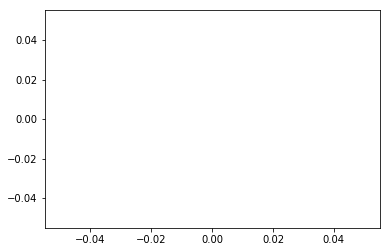

In [18]:
plt.plot(lossHist)

In [ ]:
startEpoch = len(lossHist)
train = 1
for epoch in range(startEpoch,startEpoch+300*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(batchL,batchS,_) in tqdm.tqdm_notebook(enumerate(text2MelLoader)):
        batchL = batchL.to(dev)
        batchS = batchS.to(dev)
        bL = ch.autograd.Variable(batchL)
        bS = ch.autograd.Variable(batchS)
        Shat,A = text2Mel(bL,bS)
        melloss = MelFun(Shat[:,:,:-1],bS[:,:,1:])
        attloss = GAttFun(A)
        loss = melloss + attloss
        epochLoss.append(loss.data.item())
        text2MelOpt.zero_grad()
        loss.backward()
        text2MelOpt.step()
#         if step > 1: break
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',lossHist[-1],
      'mel',melloss.data.item(),'att',attloss.data.item())
    if epoch % 10 == 0:
        state = {
            'epoch': epoch + 1,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'modelState': text2Mel.state_dict(),
            'lossHist': lossHist,
            'bestLoss': min(lossHist[-1],bestLoss),
            'optimizerState': text2MelOpt.state_dict() 
        }
        saveChkpt(state,model='text2Mel')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Shat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

EPOCH 0


In [109]:
import datasets
reload(datasets)

nWorkers = 8 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)

ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)

ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)

load = 0
if load:
    startEpoch,lossHist,bestLoss = loadChkpt(ssrn,ssrnOpt,dev)
else:
    # COLD START - RESET SSRN
    ssrn = SSRN(c=params.c,F=params.F,Fp=params.Fp).to(dev)
    ssrnOpt = ch.optim.Adam(ssrn.parameters(),
                        lr=params.lr,betas=(params.b1,params.b2),eps=params.eps)
    startEpoch,lossHist,bestLoss = 0,[],float('inf')

TypeError: unsupported operand type(s) for +: 'SSRN' and 'str'

In [32]:
startEpoch = len(lossHist)
train = 0
for epoch in range(startEpoch,startEpoch+50*train):
    print("EPOCH",epoch)
    epochLoss = []
    for step,(_,batchS,batchY) in tqdm.tqdm_notebook(enumerate(ssrnLoader)):
        batchS = batchS.to(dev)
        batchY = batchY.to(dev)
        bS = ch.autograd.Variable(batchS)
        bY = ch.autograd.Variable(batchY)
        Yhat = ssrn(bS)
        loss = MelFun(Yhat,bY)
        epochLoss.append(loss.data.item())
        ssrnOpt.zero_grad()
        loss.backward()
        ssrnOpt.step()
    lossHist.append(np.mean(epochLoss))
    print('epoch',epoch,'total',np.mean(lossHist))
    if epoch % 10 == 0:
        state = {
            'epoch': epoch + 1,
            'archparams': {'sep': params.sep, 'alpha': params.alpha},
            'modelState': ssrn.state_dict(),
            'lossHist': lossHist,
            'bestLoss': min(lossHist[-1],bestLoss),
            'optimizerState': ssrnOpt.state_dict() 
        }
        saveChkpt(state,model='ssrn')
        plt.imshow(bS[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(bY[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        plt.imshow(Yhat[0].cpu().detach().numpy(),cmap='gray')
        plt.show()
        if len(lossHist) > 10: plt.plot(lossHist)

In [33]:
L,S,Y = datasets.LJSpeechDataset(ttmel=1).__getitem__(1)
L.shape,S.shape,Y.shape

(torch.Size([180]), torch.Size([80, 217]), torch.Size([513, 868]))

In [35]:
print(dev)
dev = 'cpu'
print(dev)
text2Mel = text2Mel.eval().to(dev)
audioDec = audioDec.eval().to(dev)
ssrn = ssrn.eval().to(dev)

cpu
cpu


In [90]:
text = "Bears. Beets. Battlestar Galactica".lower()
# text = "four score and seven years ago".lower()
# text = "how cow brown now".lower()
L = ch.Tensor([params.c2i[c] for c in text])
L = ch.cat((L,ch.zeros(180-L.shape[0])))
L = L.type(ch.LongTensor).to(dev).unsqueeze(0)

In [91]:
# initial audio enc
# S = ch.zeros((80,217)).to(dev).unsqueeze(0)
s0 = ch.zeros((80,1)).to(dev).unsqueeze(0)
S = s0

In [92]:
with ch.no_grad():
    for t in tqdm.tqdm_notebook(range(100)):
        Rp,A = text2Mel(L,S[:,:,-100:])
        Shat = audioDec(Rp)
#         S[:,:,t+1] = Shat[:,:,t]
        S = ch.cat((s0,Shat),dim=2)
#         S = ch.cat((S,Shat[:,:,-1:]),dim=2)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [93]:
Y = ssrn(S)
# Y[Y<0] = 0 # doesn't happen
T = Y ** (params.eta / params.gamma) * 50
T = T.cpu().detach().numpy().astype(np.float64)
T = T[0].T
T[T<0] = 0

lwsProc = lws.lws(params.nFFT,params.hopL,mode='speech',fftsize=params.nFFT)
T = lwsProc.run_lws(T)
T = lwsProc.istft(T)

In [94]:
ipd.Audio(T,rate=22050)

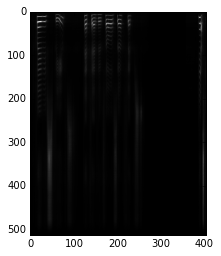

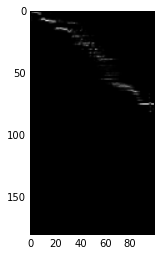

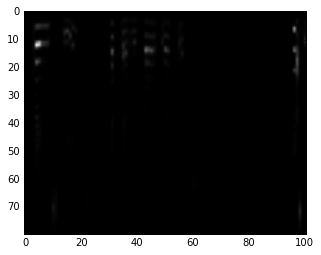

In [95]:
plt.imshow(Y[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(A[0].cpu().detach().numpy(),cmap='gray')
plt.show()
plt.imshow(S[0].cpu().detach().numpy(),cmap='gray')
plt.show()